In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import plotly
plotly.offline.init_notebook_mode(connected=True)
import plotly.offline as py
import plotly.graph_objs as go

In [3]:


installs = pd.read_csv('installs.csv')
installs["created"] =  pd.to_datetime(installs["created"], errors = "coerce") #parseo de fechas
installs.drop('attributed', axis = 1, inplace = True) #son todas false
installs.drop('click_hash', axis = 1, inplace = True) #son todas NaN

In [4]:
clicks_dtypes = {'advertiser': np.int8, 'action_id': np.float16, 'source_id': np.int8, 'country_code': 'category',
                 'latitude': np.float16, 'longitude': np.float16, 'carrier_id': np.float16, 'brand': np.float16,
                 'touchX': np.float16, 'touchY': np.float16}

clicks = pd.read_csv('clicks.csv', dtype = clicks_dtypes)
clicks["created"] =  pd.to_datetime(clicks["created"], errors = "coerce") #parseo de fechas
clicks.drop('action_id', axis = 1, inplace = True) #todos NaN
clicks.drop('wifi_connection', axis = 1, inplace = True) #todos False

In [5]:
events = pd.read_csv('events.csv', low_memory=False)

events["date"] =  pd.to_datetime(events["date"], errors = "coerce")

In [6]:
auctions = pd.read_csv('auctions.csv')
auctions["date"] =  pd.to_datetime(auctions["date"], errors = "coerce")
auctions.drop('auction_type_id', axis = 1, inplace = True)  #todas Nan

# Analisis de user agent

In [7]:
installs.columns

Index(['created', 'application_id', 'ref_type', 'ref_hash', 'implicit',
       'device_countrycode', 'device_brand', 'device_model',
       'session_user_agent', 'user_agent', 'event_uuid', 'kind', 'wifi',
       'trans_id', 'ip_address', 'device_language'],
      dtype='object')

In [8]:
events.columns

Index(['date', 'event_id', 'ref_type', 'ref_hash', 'application_id',
       'attributed', 'device_countrycode', 'device_os_version', 'device_brand',
       'device_model', 'device_city', 'session_user_agent', 'trans_id',
       'user_agent', 'event_uuid', 'carrier', 'kind', 'device_os', 'wifi',
       'connection_type', 'ip_address', 'device_language'],
      dtype='object')

In [9]:
auctions.columns

Index(['country', 'date', 'device_id', 'platform', 'ref_type_id', 'source_id'], dtype='object')

In [10]:
clicks.columns

Index(['advertiser_id', 'source_id', 'created', 'country_code', 'latitude',
       'longitude', 'carrier_id', 'trans_id', 'os_minor', 'agent_device',
       'os_major', 'specs_brand', 'brand', 'timeToClick', 'touchX', 'touchY',
       'ref_type', 'ref_hash'],
      dtype='object')

In [11]:
installs.implicit.value_counts()

False    2547
True      865
Name: implicit, dtype: int64

In [12]:
def obtener_grafo(df):
    df_from = []
    df_to = []
    last_event = None
    last_ref = None
    for a,row in df.iterrows():
        event = row["event_id"]
        ref = row["ref_hash"]
        
        if ref != last_ref:
            event == None
        elif(event and event != last_event):
            df_from.append(last_event)
            df_to.append(event)
        
        last_ref = ref
        last_event = event
    return pd.DataFrame({"from":df_from,"to":df_to}).drop_duplicates()
        

In [13]:
grafo_eventos = events.loc[events['ref_hash'].isin(installs["ref_hash"].unique()),["date","event_id","ref_hash"]]
grafo_eventos.sort_values("date",inplace=True)
grafo_eventos.sort_values("ref_hash",inplace=True)
grafo_eventos_aristas = obtener_grafo(grafo_eventos)
grafo_eventos_aristas.head(3)

,from,to
0,82,1
1,1,82
2,82,81


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning:

isinstance(..., numbers.Number)



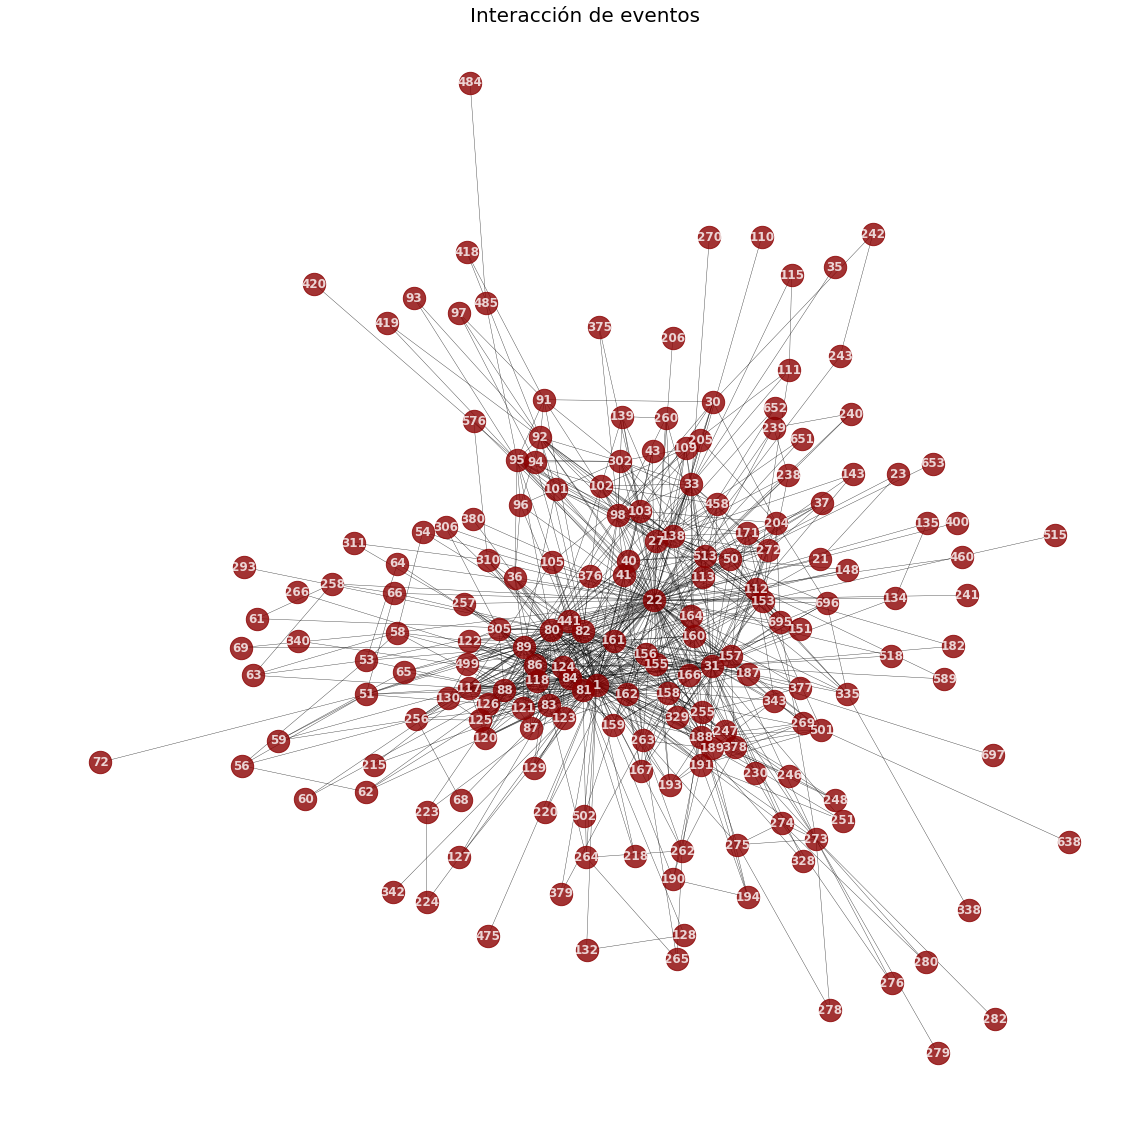

In [14]:
import networkx as nx
 
G=nx.from_pandas_edgelist(grafo_eventos_aristas, 'from', 'to')
plt.figure(figsize=(15,15)) 
nx.draw(G, alpha=0.8, node_size=500, width=0.4, node_color="darkred",font_color="white", font_weight="bold",with_labels=True)
plt.title("Interacción de eventos",size=20)
plt.show()

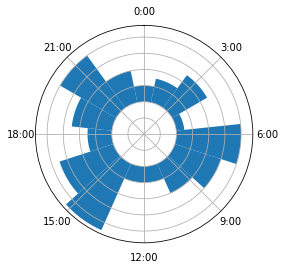

In [15]:
N = 24
bottom = 4
max_height = 10

radii = [2,3,5,1,8,6,4,2,2,9,7,3,5,8,4] 
theta = np.linspace(0.0, 2 * np.pi, len(radii), endpoint=False)
width = (2*np.pi) / len(radii)

ax = plt.subplot(111, polar=True)
bars = ax.bar(theta, radii, width=width, bottom=bottom)
ax.set_yticklabels([])
ax.set_theta_direction(-1)
ax.set_theta_zero_location("N")
ax.set_xticklabels(['0:00', '3:00', '6:00', '9:00', '12:00', '15:00', '18:00', '21:00'])

plt.show()

In [16]:
fig = {
  "data": [
    {
      "values": installs["implicit"].value_counts(),
      "text": [
        "No implicito",
        "Implicito"
      ],
      "hole": .5,
      "type": "pie"
    }],
  "layout": {
        "title":"Porcentaje de installs implícito",
      "showlegend":False,
      "annotations": [
            {
                "font": {
                    "size": 20
                },
                "showarrow": False,
                "text": "Installs"
            }
        ]
    }
}
py.offline.iplot(fig)

In [17]:
installs_to_join = installs.loc[:, ["ref_hash","application_id","created"]]
installs_to_join = installs_to_join.groupby(["ref_hash","application_id"]).agg({"created":"min"}).reset_index()
installs_to_join["index"] = installs_to_join.index
installs_to_join.head()

,ref_hash,application_id,created,index
0,4958526679100225,10,2019-03-09 15:24:03.123,0
1,5610335643679608,7,2019-03-08 23:56:00.134,1
2,12589600065022004,8,2019-03-11 03:01:40.186,2
3,13755514797422075,7,2019-03-11 22:13:03.705,3
4,14817751128061288,7,2019-03-13 02:43:14.119,4


In [18]:
evn_and_installs = events.loc[:,["date","ref_hash","application_id"]]\
    .merge(installs_to_join,left_on=["ref_hash","application_id"],right_on=["ref_hash","application_id"],how="inner")
evn_and_installs["diff"] = (evn_and_installs["date"] - evn_and_installs["created"]) / np.timedelta64(1, 'h')
#evn_and_installs = evn_and_installs.loc[(evn_and_installs["diff"] > 0) & (auc_and_installs["diff"] < cant_horas_anteriores)]
#evn_and_installs = evn_and_installs.groupby(["device_id","index"]).agg({"ref_hash":"count"})
evn_and_installs["diff"] = evn_and_installs["diff"].astype(int)
evn_and_installs = evn_and_installs.loc[evn_and_installs["diff"] >= 0]
evn_and_installs.head(10)



,date,ref_hash,application_id,created,index,diff
0,2019-03-10 22:24:56.684,8355110941557237501,0,2019-03-10 22:24:56.684,2744,0
1,2019-03-11 21:21:05.855,1670430602051291592,0,2019-03-11 21:21:05.855,567,0
2,2019-03-11 03:47:22.802,4306303321567254439,0,2019-03-11 03:47:22.802,1409,0
3,2019-03-13 01:43:35.415,8464844987297247076,0,2019-03-13 01:43:33.445,2778,0
4,2019-03-13 04:20:57.666,7953318831018100268,0,2019-03-13 04:20:57.666,2624,0
5,2019-03-13 04:58:34.835,3250564871270161533,0,2019-03-13 04:58:35.078,1069,0
6,2019-03-07 23:14:50.587,7207550682989488408,7,2019-03-06 17:30:03.420,2385,29
7,2019-03-07 23:14:52.713,7207550682989488408,7,2019-03-06 17:30:03.420,2385,29
8,2019-03-06 17:30:48.895,7207550682989488408,7,2019-03-06 17:30:03.420,2385,0
9,2019-03-07 23:14:54.389,7207550682989488408,7,2019-03-06 17:30:03.420,2385,29


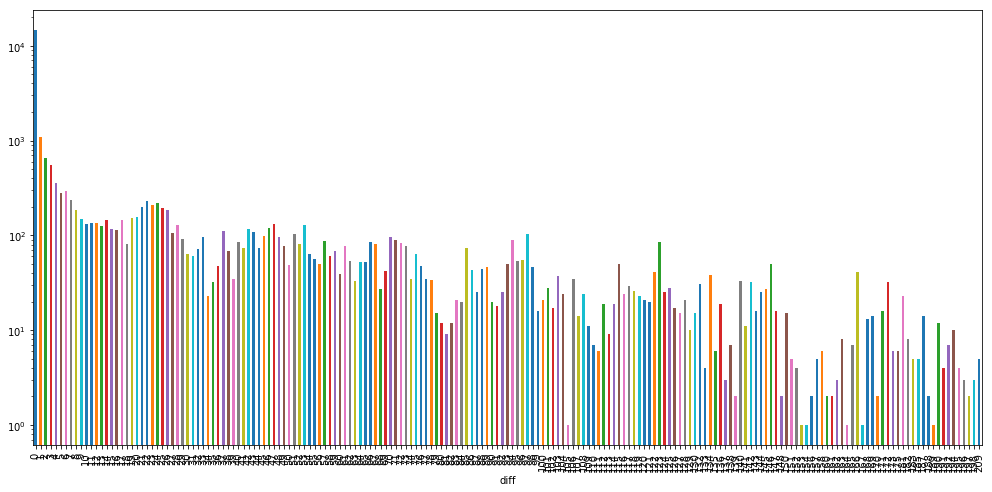

In [19]:
ax = evn_and_installs.groupby(["diff"]).agg({"application_id":"count"})["application_id"].plot(kind="bar",figsize=(17,8))
ax.set_yscale("log")
ax

In [20]:
evn_and_installs.groupby(["ref_hash","diff"]).agg({"application_id":"count"})

application_id
ref_hash            diff                
4958526679100225    0                  6
12589600065022004   0                 19
                    8                  6
                    14                 6
                    18                 5
                    22                 9
                    31                 5
                    38                13
                    41                 5
                    44                 5
                    46                10
                    58                 2
14817751128061288   0                  2
17437441331211593   0                  1
19615030838209300   0                  2
23616099694325670   0                  6
                    96                 7
36976639880313368   0                  1
37096755231769399   0                  3
                    6                  6
                    63                10
46611672913094786   0                  7
46980413962192992   0                  2
50280819545059620   0                  3
59130019413178483   0                  1
61509282915612682   0                  3
62812756488497420   0                  5
63351004190773791   0                  1
63497792339706584   0                 21
63706564589198060   0                  9
...                                  ...
9195863858643819478 19                 5
                    20                 1
                    21                 4
                    25                14
                    26                10
                    27                 7
                    40                 2
                    44                 2
                    45                 1
                    47                 5
                    48                 2
                    60                 4
                    61                 1
                    65                12
                    68                 2
                    72                 3
                    73                12
                    88                 4
                    98                 4
                    99                 2
                    101               10
9200792220316607917 0                 14
9207344317113023690 0                 29
9214260860852312640 0                  8
                    71                16
9218176775394019607 0                  2
9218934271985603444 0                 31
                    1                  2
                    10                 7
                    22                 3

[5265 rows x 1 columns]

In [21]:
cant_horas_anteriores = 48
installs_to_join = installs.loc[ installs["created"] > pd.to_datetime("2019-03-07") , ["ref_hash","application_id","created"]]
installs_to_join = installs_to_join.groupby(["ref_hash","application_id"]).agg({"created":"min"}).reset_index()
installs_to_join["index"] = installs_to_join.index
installs_to_join.head()

,ref_hash,application_id,created,index
0,4958526679100225,10,2019-03-09 15:24:03.123,0
1,5610335643679608,7,2019-03-08 23:56:00.134,1
2,12589600065022004,8,2019-03-11 03:01:40.186,2
3,13755514797422075,7,2019-03-11 22:13:03.705,3
4,14817751128061288,7,2019-03-13 02:43:14.119,4


In [22]:
auc_and_installs = auctions.loc[:,["date","device_id"]].merge(installs_to_join,left_on="device_id",right_on="ref_hash",how="inner")
auc_and_installs["diff"] = (auc_and_installs["created"] - auc_and_installs["date"]) / np.timedelta64(1, 'h')
auc_and_installs = auc_and_installs.loc[(auc_and_installs["diff"] > 0) & (auc_and_installs["diff"] < cant_horas_anteriores)]
auc_and_installs = auc_and_installs.groupby(["device_id","index"]).agg({"ref_hash":"count"})
auc_and_installs = auc_and_installs.reset_index()
auc_and_installs.head()


,device_id,index,ref_hash
0,5610335643679608,1,11
1,17437441331211593,5,3
2,61509282915612682,14,1
3,67443465839184775,18,1
4,107282684840551622,25,9


In [23]:
def get_rango(serie):
    lista=[]
    for i in list(serie):
        if i <= 10:
            lista.append("rango 1")
        elif i <= 10:
            lista.append("rango 2")
        else:
            lista.append("rango 3")
    return lista
auc_and_installs["rango"] = get_rango(auc_and_installs["ref_hash"])

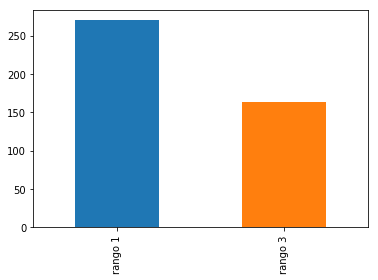

In [24]:
auc_and_installs["rango"].value_counts().plot(kind="bar")

In [25]:
trace0 = go.Box(
    y=list(auc_and_installs["ref_hash"])
)
data = [trace0]
py.iplot(data)

In [26]:
auc_and_installs["ref_hash"].mean()

23.66512702078522

In [27]:
list(auc_and_installs["ref_hash"])

[11,
 3,
 1,
 1,
 9,
 41,
 19,
 4,
 1,
 9,
 5,
 10,
 1,
 5,
 224,
 3,
 1,
 14,
 58,
 23,
 4,
 1,
 2,
 23,
 7,
 22,
 3,
 32,
 2,
 1,
 2,
 2,
 3,
 46,
 5,
 3,
 1,
 1,
 107,
 37,
 1,
 9,
 10,
 10,
 3,
 1,
 1,
 1,
 1,
 4,
 52,
 5,
 1,
 5,
 12,
 7,
 6,
 3,
 25,
 1,
 1,
 1,
 44,
 43,
 22,
 1,
 1,
 1,
 1,
 12,
 3,
 1,
 13,
 2,
 4,
 1,
 37,
 1,
 58,
 3,
 44,
 7,
 9,
 17,
 26,
 3,
 2,
 15,
 24,
 1,
 2,
 5,
 7,
 2,
 361,
 1,
 22,
 98,
 11,
 26,
 2,
 1,
 2,
 114,
 1,
 2,
 29,
 17,
 1,
 39,
 1,
 1,
 498,
 5,
 1,
 1,
 3,
 2,
 69,
 1,
 12,
 2,
 4,
 4,
 1,
 20,
 11,
 29,
 16,
 2,
 5,
 42,
 126,
 6,
 7,
 3,
 2,
 2,
 1,
 22,
 1,
 104,
 1,
 21,
 3,
 49,
 3,
 2,
 4,
 2,
 32,
 6,
 17,
 3,
 101,
 1,
 114,
 7,
 2,
 1,
 48,
 84,
 5,
 1,
 73,
 1,
 83,
 6,
 28,
 5,
 4,
 3,
 5,
 16,
 9,
 34,
 10,
 1,
 1,
 6,
 9,
 4,
 312,
 34,
 53,
 121,
 2,
 1,
 8,
 1,
 1,
 2,
 5,
 9,
 3,
 2,
 1,
 19,
 7,
 21,
 18,
 114,
 7,
 2,
 15,
 1,
 2,
 1,
 1,
 11,
 3,
 6,
 11,
 1,
 1,
 15,
 14,
 3,
 2,
 72,
 6,
 7,
 2,
 218,
 95,
 45,
 

In [37]:
events.event_id.value_counts()

22     618228
31     417070
161    217846
1      157812
138    100039
162     84898
329     56490
156     53332
33      48581
171     43942
310     42101
155     38465
273     37056
23      35588
21      26228
98      24301
158     23738
272     22788
80      22076
50      20905
81      18622
346     14408
58      13940
51      13455
513     12682
354     11711
133     11074
256     10939
274     10035
60       9456
        ...  
500         1
511         1
532         1
516         1
132         1
520         1
521         1
523         1
575         1
577         1
578         1
579         1
608         1
433         1
597         1
436         1
589         1
588         1
587         1
586         1
585         1
140         1
583         1
581         1
580         1
437         1
443         1
227         1
226         1
584         1
Name: event_id, Length: 568, dtype: int64

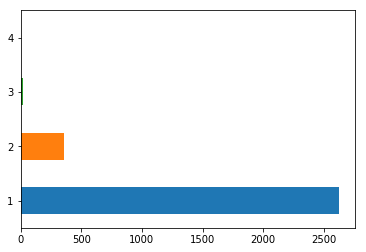

In [34]:
installs.groupby("ref_hash").agg({"created":"count"})["created"].value_counts().plot(kind="barh")